#### Load the necessary module and make the connection to CAS

In [2]:
import os
import pandas as pd
import swat
from _config import login
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [10]:
user, pswd, host = login()
conn = swat.CAS(hostname=host, port=8777,
                username=user, password=pswd, protocol='http')

In [4]:
conn.about()

NOTE: Grid node action status report: 1 nodes, 9 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Copyright': 'Copyright Â© 2014-2018 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2019-12-18T23:37:05Z',
  'System': {'Hostname': 'sasserver',
   'Linux Distribution': 'CentOS release 6.9 (Final)',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '2.6.32-696.18.7.el6.x86_64',
   'OS Version': '#1 SMP Thu Jan 4 17:31:22 UTC 2018'},
  'Version': '3.04',
  'VersionLong': 'V.03.04M0P07122018',
  'license': {'expires': '09Sep2020:00:00:00',
   'gracePeriod': 45,
   'maxCPUs': 9999,
   'site': 'DEMOCENTER - Production 19W34 09 09 2012',
   'siteNum': 70180938,
   'warningPeriod': 45}}

[nodestatus]

 Node Status
 
                      name        role  uptime  running  stalled
 0  sasserver.demo.sas.com  controller  12.149        0        0

[server]

 Server Status
 
    nodes  actions
 0      1        9

+ Elapsed: 0.000814s, sys: 0.000999s, mem: 0.312mb

#### Figure out which action set contains the actions that pertain to stabilty monitoring and load that actionset

In [5]:
module = conn.actionsetinfo(all=1)['setinfo']['actionset'][conn.actionsetinfo(
    all=1)['setinfo']['actionset'].str.contains(pat='stability', case=False)]

conn.loadactionset(list(module)[0])

NOTE: Added action set 'stabilityMonitoring'.


[actionset]

 'stabilityMonitoring'

+ Elapsed: 0.00137s, sys: 0.001s, mem: 0.214mb

#### Read the input data to build the model and check out how the data looks

In [3]:
df = pd.read_excel('/Users/sagang/Downloads/train_FD003_Engine24.xlsx')
df.head()

,Engine_Number,Cycle_Number,Operation_Mode_1,Operation_Mode_2,Operation_Mode_3,Total_temperature_at_fan_inlet,Total_temperature_at_LPC_outlet,Total_temperature_at_HPC_outlet,Total_temperature_at_LPT_outlet,Pressure_at_fan_inlet,...,Ratio_of_fuel_flow_to_Ps30,Corrected_fan_speed,Corrected_core_speed,Bypass_ratio,Burner_fuel_air_ratio,Bleed_enthalpy,Demanded_fan_speed,Demanded_corrected_fan_speed,HPT_coolant_bleed,LPT_coolant_bleed
0,24,1,-0.0003,-0.0001,100,518.67,641.55,1579.97,1396.86,14.62,...,519.25,2387.65,8116.67,8.4219,0.03,390,2388,100,38.78,23.2995
1,24,2,-0.0025,-0.0001,100,518.67,641.78,1577.83,1390.03,14.62,...,520.60,2387.91,8124.89,8.4022,0.03,391,2388,100,39.12,23.3948
2,24,3,-0.0024,0.0004,100,518.67,642.03,1585.89,1397.09,14.62,...,519.26,2387.35,8112.68,8.4065,0.03,390,2388,100,38.89,23.3420
3,24,4,0.0002,0.0003,100,518.67,641.93,1583.73,1397.19,14.62,...,518.61,2387.48,8119.49,8.4702,0.03,389,2388,100,38.83,23.2713
4,24,5,-0.0014,0.0002,100,518.67,642.17,1586.38,1392.98,14.62,...,519.90,2387.49,8121.72,8.4158,0.03,389,2388,100,38.93,23.3693


Standardize the columns

In [4]:
df.columns = [i.lower().replace('-', '')
              for i in df.columns]  # standardize col names

Load Table into CAS, also replace any existing table.

In [9]:
cas_tbl = 'sm_base'
caslib = 'public'
cas_df = conn.upload_frame(df, casout=dict(
    caslib=caslib, name=cas_tbl, replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table SM_BASE in caslib public.
NOTE: The table SM_BASE has been created in caslib public from binary data uploaded to Cloud Analytic Services.


Confirm table is loaded  & toggle to Public Caslib

In [10]:
conn.setsessopt(caslib='Public')
conn.tableinfo()

NOTE: 'Public' is now the active caslib.


,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,SM_BASE,494,26,0,utf-8,2019-12-18T18:37:23-05:00,2019-12-18T18:37:23-05:00,2019-12-18T18:37:23-05:00,UTF8,1.892331e+09,...,0,0,0,,,0,sasdemo,,2019-12-18T18:37:23-05:00,1.892331e+09


In [11]:
train = cas_df[cas_df['cycle_number'] <= 90]
train['stable'] = 1
train.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,engine_number,1,double,8,12,0,0
1,cycle_number,2,double,8,12,0,0
2,operation_mode_1,3,double,8,12,0,0
3,operation_mode_2,4,double,8,12,0,0
4,operation_mode_3,5,double,8,12,0,0
5,total_temperature_at_fan_inlet,6,double,8,12,0,0
6,total_temperature_at_lpc_outlet,7,double,8,12,0,0
7,total_temperature_at_hpc_outlet,8,double,8,12,0,0
8,total_temperature_at_lpt_outlet,9,double,8,12,0,0
9,pressure_at_fan_inlet,10,double,8,12,0,0


In [12]:
train[['cycle_number', 'ratio_of_fuel_flow_to_ps30', 'stable']
      ].describe()  # we'll use cycle_number is  TimeID

,cycle_number,ratio_of_fuel_flow_to_ps30,stable
count,90.000000,90.000000,90.0
mean,45.500000,519.350889,1.0
std,26.124701,0.532002,0.0
min,1.000000,518.380000,1.0
25%,23.000000,519.050000,1.0
50%,45.500000,519.265000,1.0
75%,68.000000,519.490000,1.0
max,90.000000,520.940000,1.0


Now persist the view on the server side by creating a new CASTable

In [13]:
train_tbl = train.partition()  # persist changes
train_tbl = train_tbl.casTable  # get CASTable

Check out the data - especially the target and the datetime variable

In [14]:
train_tbl[['cycle_number', 'ratio_of_fuel_flow_to_ps30']].tail(10)

,cycle_number,ratio_of_fuel_flow_to_ps30
80,81.0,519.05
81,82.0,519.33
82,83.0,519.49
83,84.0,518.81
84,85.0,519.19
85,86.0,519.08
86,87.0,520.40
87,88.0,520.84
88,89.0,518.89
89,90.0,520.52


Set up the stability monitoring models by configuring project specifications using the stability monitoring calibration action. 

Its recommended that you read about the action set [here](https://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.5&docsetId=casactforecast&docsetTarget=casactforecast_stabilitymonitoring_details01.htm&locale=en) before you start working with the actions.

In [15]:
input_vars = ['pressure_at_fan_inlet', 'total_pressure_in_bypassduct',
              'corrected_core_speed', 'bleed_enthalpy', 'hpt_coolant_bleed', 'lpt_coolant_bleed']
target = 'ratio_of_fuel_flow_to_ps30'
datetime_variable = 'cycle_number'
stability_indicator = 'stable'

default_model_spec = {'xvarnames': input_vars,
                      'xtsf': ['none', 'none', 'none', 'none', 'none', 'none'],
                      'xreqlist': ['0', '0', '0', '0', '0', '0'],
                      'targettsf': 'none'}

models = [dict(id=1, type='REG'),
          dict(id=2, type='ARIMA')]

results = conn.stabilitymonitoring.smcalib(
    projdefs=[
        {
            'id': 1,
            'modellist': models,
            'projvars': dict(xvarnames=input_vars,
                             targetname=target,
                             dttmvarname=datetime_variable,
                             stablevarname=stability_indicator),
            'modelvars': [default_model_spec for i in range(len(models))],
            'projdata':train_tbl
        }
    ],
    projouttable=dict(name='outtab', replace=True),
    holdoutfittable=dict(name='holdout', replace=True),
    scoreouttable=dict(name='scoretable', replace=True),
    scoreinfotable=dict(name='scoreinfotab', replace=True)
)

NOTE:  Calibrating project ID = 1.
NOTE:  Calibration successful for project ID = 1, model ID = 0.
NOTE:  Calibration successful for project ID = 1, model ID = 1.
NOTE:  Calibration successful for project ID = 1, model ID = 2.


In [16]:
results

[CalibStatus]

 Calibration Status
 
    ProjectID  ModelID  Status  RC                          Message
 0          1        0       0   0  Command successfully completed.
 1          1        1       0   0  Command successfully completed.
 2          1        2       0   0  Command successfully completed.

[FitStats]

 Fit Statistics
 
    ProjectID  ModelID         AIC         SBC      MAPE    AdjRSq      RMSE  \
 0          1        0 -112.605030 -110.105220  0.070602  0.000000  0.529038   
 1          1        1 -194.995130 -179.996272  0.048686  0.620438  0.316645   
 2          1        2 -196.771317 -174.273030  0.045187  0.638962  0.303257   
 
      Sigma2  
 0  0.283026  
 1  0.107426  
 2  0.102183  

[HoldoutStats]

 Holdout Statistics
 
    ProjectID  ModelID      MAPE      RMSE
 0          1        0  0.118504  0.704429
 1          1        1  0.059342  0.360965
 2          1        2  0.058863  0.351435

[OutputCasTables]

    casLib          Name         Label  Rows  Columns  \
 0  Public        outtab                 270        8   
 1  Public       holdout                  30        8   
 2  Public    scoretable                   1        2   
 3  Public  scoreinfotab  Scoring Info    79        4   
 
                                     casTable  
 0        CASTable('outtab', caslib='Public')  
 1       CASTable('holdout', caslib='Public')  
 2    CASTable('scoretable', caslib='Public')  
 3  CASTable('scoreinfotab', caslib='Public')  

[ScoreParameters]

 Parameter Estimates
 
    ProjectID  ModelID                           Var  Transform   Estimate  \
 0          1        1  total_pressure_in_bypassduct          0  35.354888   
 1          1        1          corrected_core_speed          0   0.042049   
 2          1        1                bleed_enthalpy          0   0.141208   
 3          1        1             hpt_coolant_bleed          0   1.234295   
 4          1        1             lpt_coolant_bleed          0   1.619062   
 5          1        2  total_pressure_in_bypassduct          0  27.256138   
 6          1        2          corrected_core_speed          0   0.039770   
 7          1        2                bleed_enthalpy          0   0.138502   
 8          1        2             hpt_coolant_bleed          0   1.393553   
 9          1        2             lpt_coolant_bleed          0   1.582010   
 
      StdErr    tValue         Probt  
 0  8.761565  4.035225  1.197837e-04  
 1  0.008534  4.927008  4.136617e-06  
 2  0.039381  3.585653  5.634676e-04  
 3  0.331525  3.723079  3.551467e-04  
 4  0.549924  2.944156  4.187121e-03  
 5  8.158455  3.340846  1.265153e-03  
 6  0.007097  5.604005  2.802178e-07  
 7  0.036006  3.846586  2.376435e-04  
 8  0.282307  4.936302  4.192238e-06  
 9  0.439801  3.597106  5.520431e-04  

+ Elapsed: 0.0862s, user: 0.062s, sys: 0.026s, mem: 5.04mb

##### Compare the models using their holdout MAPE

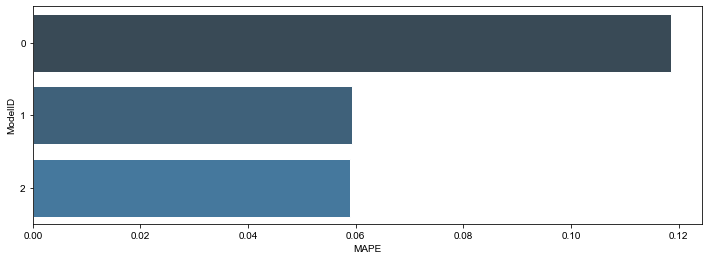

In [17]:
f, ax = plt.subplots(figsize=(12, 4))
sns.set(style="whitegrid")
sns.barplot(x='MAPE', y='ModelID', data=results.HoldoutStats[[
            'ModelID', 'MAPE']], orient='h', palette=sns.color_palette("Blues_d"))

Download the CASTable as a dataframe that holds the predictions for the holdout data

In [18]:
holdout_df = conn.CASTable(
    'holdout')[['TimeID', 'Actual', 'Pred', 'LCL', 'UCL', 'ModelID']].to_frame()
holdout_df = holdout_df.set_index('TimeID')

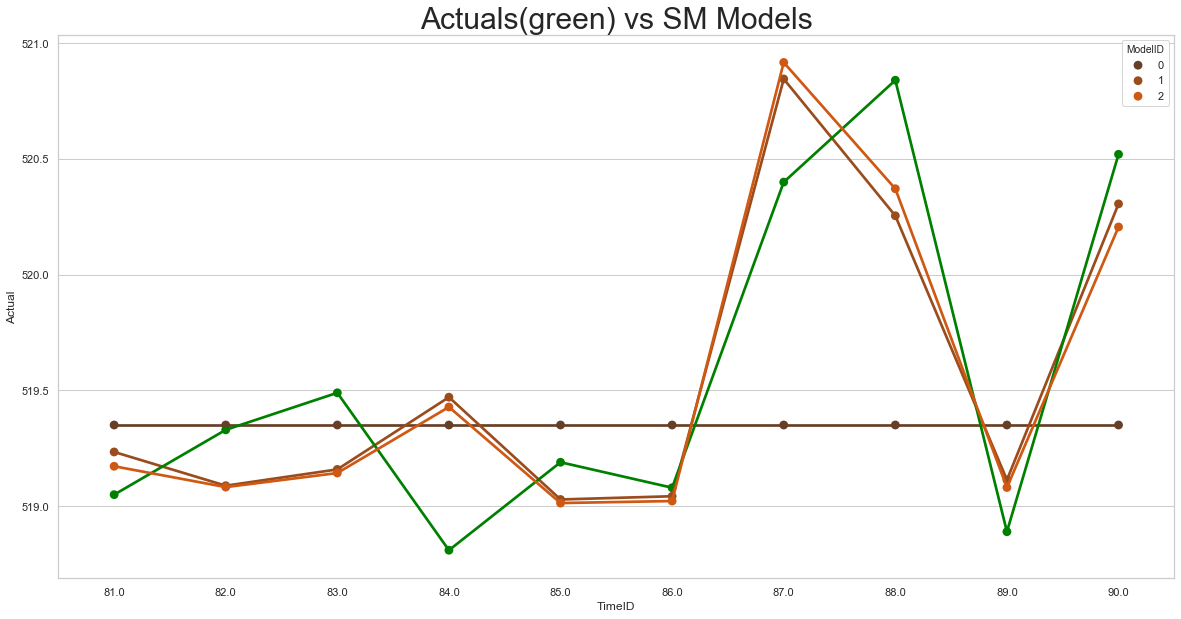

In [19]:
f, ax = plt.subplots(figsize=(20, 10))
plt.title('Actuals(green) vs SM Models', fontdict=dict(fontsize=30))
sns.set_style('whitegrid')
sns.pointplot(holdout_df.index, 'Pred', data=holdout_df,
              hue='ModelID', palette=sns.color_palette("Oranges_d"))
sns.pointplot(holdout_df.index, 'Actual', data=holdout_df,
              color='green')

Select the top model based on MAPE on model hold out stats

In [20]:
best_model_df = results['HoldoutStats'].sort_values(by='MAPE')
print("***** The following is the champion model***")
best_model_df.head(1)

***** The following is the champion model***


,ProjectID,ModelID,MAPE,RMSE
2,1,2,0.058863,0.351435


Fetch the scoring data

In [21]:
score = cas_df[(cas_df['cycle_number'] >= 91) &
               (cas_df['cycle_number'] <= 140)]
score['cycle_number'].nunique()

50

Persist the score table and Score it with the ASTORE action

In [22]:
score_tbl = score.partition()  # persist changes
score_tbl = score_tbl.casTable  # get CASTable

Describe the ASTORE generated

In [25]:
conn.loadactionset('astore')
conn.describe('scoretable')

NOTE: Added action set 'astore'.


[Description]

          Attribute               Value
 0  Analytic Engine                  sm
 1     Time Created  18Dec2019:18:37:49

[InputVariables]

 Input Variables
 
                            Name  Length   Role      Type RawType FormatName
 0                  cycle_number     8.0  Input  Interval     Num           
 1    ratio_of_fuel_flow_to_ps30     8.0  Input  Interval     Num           
 2         pressure_at_fan_inlet     8.0  Input  Interval     Num           
 3  total_pressure_in_bypassduct     8.0  Input  Interval     Num           
 4          corrected_core_speed     8.0  Input  Interval     Num           
 5                bleed_enthalpy     8.0  Input  Interval     Num           
 6             hpt_coolant_bleed     8.0  Input  Interval     Num           
 7             lpt_coolant_bleed     8.0  Input  Interval     Num           

[Key]

                                         Key
 0  CB9420C9435EC3CD00A8F993BA27148F93E7755B

[OutputVariables]

 Output Variables
 
      Name  Length Type                   Label
 0  TimeID     8.0  Num                 Time ID
 1  Actual     8.0  Num                  Actual
 2    Pred     8.0  Num               Predicted
 3     LCL     8.0  Num  Lower Confidence Limit
 4     UCL     8.0  Num  Upper Confidence Limit
 5   Error     8.0  Num                   Error

+ Elapsed: 0.00429s, user: 0.001s, sys: 0.003s, mem: 2.97mb

Score with the ASTORE

In [26]:
conn.score(table=score_tbl,
           casout=dict(name='result_out', replace=True),
           rstore='scoretable',
           options=[{'name': 'ProjectID', 'value': 1},
                    {'name': 'ModelID', 'value': 2}])

[OutputCasTables]

    casLib        Name  Rows  Columns                                 casTable
 0  Public  result_out    50        6  CASTable('result_out', caslib='Public')

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.000084  0.002519
 1  Creating the State  0.003744  0.112362
 2             Scoring  0.029467  0.884310
 3               Total  0.033322  1.000000

+ Elapsed: 0.0348s, user: 0.025s, sys: 0.01s, mem: 3.76mb

IMPORT ASTORE TO MODEL MANAGER

In [28]:
from sasctl import Session
from sasctl.tasks import register_model

sm = conn.CASTable('scoretable')

with Session(hostname=f'http://{host}/cas-shared-default-http',
             username=user, password=pswd, protocol='http', port=80,
             verify_ssl=False):
    register_model(sm, 'smodel_swat', 'stability_monitoring',
                   force=True,version='latest') #set force = False  if  writing to existing project

NOTE: Added action set 'astore'.
NOTE: Cloud Analytic Services saved the file _88C8E2A612AA4BA1847259902.sashdat in caslib ModelStore.


In [13]:
conn.close()